# Predicting GPA with Deep Learning
This notebook reproduces the models and all figures and tables contained in my paper on the Fragile Familes Challenge.

***Please note the following if you intend to run this notebook***

- To the best of my knowledge this notebook will reproduce all the results accurately but due to stochastic nature of many of the processes used the results may differ. Where possible I have created static copies of objects that can be loaded directly. Some of these are too large to store on Github, for example the pickled versions of the final 5 classifiers. Please email me directly if you would like copies of these.

- This notebook is contains process that are computationally intensive and take some time to run. As is it will take at least 24 hours to run on a top spec laptop computer. I have noted the cells that take most time to run. If possible you may consider editing the notebook where appropriate to run processes in paraellel or using a GPU.




# Loading packages and data

In [1]:
# Set up to ensure reproducibility following https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import tensorflow as tf
import numpy as np
import random
import os

os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(54321)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(6789)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, CSVLogger, History
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import lime
import lime.lime_tabular
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Loading the files

***Note: These data cannot be provided on Github and I will delete my copies in accordance with the FFC agreement. If you would like copies of the data to replicate these analyses please contact the Fragile Familes survey.***

In [2]:
train=pd.read_csv('../../ff_data/train.csv',low_memory=False, index_col='challengeID')
predictions=pd.read_csv('../../ff_data/prediction.csv',low_memory=False, index_col='challengeID')

To generate `full_imputed.p` the script `clean_files.py` must first be run. If necessary it can be executed and run by uncommenting the line below.

In [ ]:
#! python clean_files.py

In [3]:
data = pd.read_pickle('full_imputed.p') # load imputed data output after running the clean_files.py

In [4]:
data.shape

(4242, 4568)

Extract the outcomes from the imputed data.

In [5]:
y = data[['gpa','grit','materialHardship','eviction','layoff','jobTraining']]
X = data
for c in X.columns:
    if c in list(y.columns):
        del X[c]

# Data processing

Before modelling the data there are two types of transformations that I use to optimize them for the neural network.

Categorical variables are transformed using one-hot encoding. Continuous variables are also normalized to have a mean of zero.

To identify which columns belong to which group I use same heuristic as in the imputation script.

In [6]:
# Identify categorical columns
cat_cols = []
non_cat_cols = []
for i, c in enumerate(X.columns):
    is_categorical = False
    vals = set(list(X[c]))
    vals = {x for x in vals if x==x} # Removes nans, otherwise treated as unique
    if X[c].dtype == 'float64': # if float and low num distinct then treat as cat
        if len(vals) <= 20:
            is_categorical = True
        else:
            pass
    else:
        is_categorical = True
    
    # Now append to relevant list of columns
    if is_categorical:
        cat_cols.append(c)
        
    else:
        non_cat_cols.append(c)

In [7]:
X_dummies = pd.get_dummies(X, columns=cat_cols)
# Note that sklearn also has one-hot encoding but doesn't relabel

In [8]:
X_dummies.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag_1.0,hv4mflag_2.0,hv4mflag_3.0,hv4mompreg_0.0,hv4mompreg_1.0,hv4selfht_0.0,hv4selfht_1.0,hv4selfht_2.0,hv4selfwt_0.0,hv4selfwt_1.0
challengeID,,,,,,,,,,,,,,,,,,,,,
1,40.0,202.485367,25.0,6.723174,13.260396,38.0,1682.415602,0.038262,2.211822,29579.694329,...,0,0,0,1,0,1,0,0,1,0
2,40.0,45.608219,43.0,16.000000,3.000000,25.0,3050.504448,0.110909,1.985703,20829.093487,...,0,0,0,0,1,1,0,0,1,0
3,35.0,39.060299,49.0,46.000000,23.000000,20.0,0.000000,12.158179,1.386592,132483.450592,...,0,0,0,1,0,1,0,0,1,0
4,30.0,22.304855,23.0,23.169628,5.699719,20.0,0.000000,4.165048,1.157385,0.000000,...,0,0,0,1,0,1,0,0,1,0
5,25.0,35.518272,90.0,64.000000,58.000000,12.0,1974.812374,12.212538,2.965919,49026.982561,...,0,0,0,1,0,1,0,0,1,0


In [9]:
normalizer = StandardScaler()
for c in non_cat_cols:
    normed = normalizer.fit_transform(X_dummies[c].values.reshape(-1,1))
    X_dummies[c] = normed

In [10]:
X_dummies.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag_1.0,hv4mflag_2.0,hv4mflag_3.0,hv4mompreg_0.0,hv4mompreg_1.0,hv4selfht_0.0,hv4selfht_1.0,hv4selfht_2.0,hv4selfwt_0.0,hv4selfwt_1.0
challengeID,,,,,,,,,,,,,,,,,,,,,
1,0.364267,0.675623,-0.545055,-0.788818,0.183309,0.255698,-0.245954,-1.512365,0.017524,-0.105330,...,0,0,0,1,0,1,0,0,1,0
2,0.364267,-0.197911,0.606432,-0.149595,-1.041256,-0.986483,-0.080941,-1.497946,-0.168142,-0.377045,...,0,0,0,0,1,1,0,0,1,0
3,-0.071568,-0.234372,0.990261,1.917563,1.345718,-1.464245,-0.448880,0.893159,-0.660072,3.089933,...,0,0,0,1,0,1,0,0,1,0
4,-0.507403,-0.327670,-0.672998,0.344430,-0.719048,-1.464245,-0.448880,-0.693293,-0.848273,-1.023809,...,0,0,0,1,0,1,0,0,1,0
5,-0.943238,-0.254094,3.613094,3.157858,5.522921,-2.228664,-0.210687,0.903948,0.636712,0.498527,...,0,0,0,1,0,1,0,0,1,0


In [11]:
X = X_dummies # rename X

Now splitting the X and y matrices to separate cases in the training set and the prediction set.

In [12]:
X_training=X.loc[X.index.isin(train.index)]
X_pred=X.loc[~X.index.isin(train.index)]

In [13]:
y_training=y.loc[y.index.isin(train.index)]
y_pred=y.loc[~y.index.isin(train.index)]

# Modeling

Randomly splitting the data into training and test sets, where 20% of data is held out for validation and testing. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training.gpa, test_size=0.20, random_state=12345)

Making a function that can be used to return Keras models with different parameter combinations.

In [15]:
def make_model(activation_function, num_hidden_layers, hidden_layer_size):
    '''
    A function to create a Keras sequential model based on input parameters.
    
    Parameters
    -----------
        activation_function: str
            Activation function to be used in model.
        
        num_hidden_layers: int
            Number of hidden layers in model
        
        hidden_layer_size: int
            Number of units/neurons in each hidden layer
            
    Returns
    ---------
    
    Keras Sequential model object
    
    '''
    
    model = Sequential()
    
    
    # Single layer model
    if num_hidden_layers == 0: # then just specify a single layer, 1 is size of output
        model.add(Dense(1, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True))
        
        model.add(Dropout(0.5))
    
    # Specify initial layer with a hidden layer
    if num_hidden_layers >= 1: 
        model.add(Dense(hidden_layer_size, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True))
        model.add(Dropout(0.5))
    
    # Now add additional hidden layers
    for i in range(0,num_hidden_layers-1):
        model.add(Dense(hidden_layer_size, 
                        activation=activation_function, 
                        use_bias=True))
        model.add(Dropout(0.5))
    
    if num_hidden_layers > 0:       
        model.add(Dense(1)) # Final output layer, don't add if no hidden layers

    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    return model

Now I take the model object and use it to initialize a classifier using the scikit-learn Keras wrapped object `KerasRegressor`.

I then define the parameter space to search over and pass both to a `GridSearchCV` object. 

Once the `fit` method is called the grid search will begin and a model will fit for every parameter combination and fold (40 x 5). 

***Note: This will take 12 hours or more to complete***


In [29]:
%%time

classifier = KerasRegressor(make_model, batch_size=32, epochs=200)

params = [{'num_hidden_layers': [0],
          'hidden_layer_size': [0],
          'activation_function': ['linear', 'sigmoid', 'relu', 'tanh']},
          {'num_hidden_layers': [1,2,3],
          'hidden_layer_size': [64, 128, 256],
          'activation_function': ['linear', 'sigmoid', 'relu', 'tanh']}]



grid = GridSearchCV(classifier,
                         param_grid=params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5,# Number of folds for CV
                         fit_params={'callbacks': [EarlyStopping(monitor='val_loss', 
                                                                 min_delta=0.001, 
                                                                 patience=25, 
                                                                 mode='min',
                                                                 verbose=2)],
                                    'validation_data': (np.array(X_test), np.array(y_test))
                                    }
                   )

grid.fit(np.array(X_train), np.array(y_train))

print('The parameters of the best model are: ')
print(grid.best_params_)

best_model = grid.best_estimator_ #scikit-wrapped best model

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] activation_function=linear, hidden_layer_size=0, num_hidden_layers=0 
Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 0s - loss: 6.1142 - val_loss: 2.1755
Epoch 2/200
1356/1356 [==============================] - 0s - loss: 4.8160 - val_loss: 4.7218
Epoch 3/200
1356/1356 [==============================] - 0s - loss: 4.7045 - val_loss: 2.1697
Epoch 4/200
1356/1356 [==============================] - 0s - loss: 4.3532 - val_loss: 2.6221
Epoch 5/200
1356/1356 [==============================] - 0s - loss: 4.2107 - val_loss: 1.2855
Epoch 6/200
1356/1356 [==============================] - 0s - loss: 4.2742 - val_loss: 2.9198
Epoch 7/200
1356/1356 [==============================] - 0s - loss: 4.5380 - val_loss: 1.6328
Epoch 8/200
1356/1356 [==============================] - 0s - loss: 4.4179 - val_loss: 1.7968
Epoch 9/200
1356/1356 [==============================] - 0s - lo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 0s - loss: 6.8739 - val_loss: 1.3018
Epoch 2/200
1357/1357 [==============================] - 0s - loss: 5.0096 - val_loss: 1.4999
Epoch 3/200
1357/1357 [==============================] - 0s - loss: 4.8760 - val_loss: 3.2300
Epoch 4/200
1357/1357 [==============================] - 0s - loss: 4.6433 - val_loss: 1.6896
Epoch 5/200
1357/1357 [==============================] - 0s - loss: 4.7495 - val_loss: 1.3174
Epoch 6/200
1357/1357 [==============================] - 0s - loss: 4.6480 - val_loss: 1.7594
Epoch 7/200
1357/1357 [==============================] - 0s - loss: 4.2823 - val_loss: 2.8059
Epoch 8/200
1357/1357 [==============================] - 0s - loss: 4.8710 - val_loss: 2.5564
Epoch 9/200
1357/1357 [==============================] - 0s - loss: 4.4257 - val_loss: 2.5013
Epoch 10/200
1357/1357 [==============================] - 0s - loss: 4.9956 - val_loss: 2.1681
Epoch 11/200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 720.1min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 9s - loss: 11.2438 - val_loss: 0.3625
Epoch 2/200
1696/1696 [==============================] - 5s - loss: 0.8811 - val_loss: 0.3404
Epoch 3/200
1696/1696 [==============================] - 5s - loss: 0.8141 - val_loss: 0.3388
Epoch 4/200
1696/1696 [==============================] - 5s - loss: 0.7413 - val_loss: 0.3381
Epoch 5/200
1696/1696 [==============================] - 5s - loss: 0.7384 - val_loss: 0.3374
Epoch 6/200
1696/1696 [==============================] - 4s - loss: 0.7181 - val_loss: 0.3399
Epoch 7/200
1696/1696 [==============================] - 5s - loss: 0.6417 - val_loss: 0.3396
Epoch 8/200
1696/1696 [==============================] - 5s - loss: 0.6388 - val_loss: 0.3373
Epoch 9/200
1696/1696 [==============================] - 5s - loss: 0.6050 - val_loss: 0.3381
Epoch 10/200
1696/1696 [==============================] - 4s - loss: 0.5589 - val_loss: 0.3397
Epoch 11/20

In [75]:
grid.best_params_

{'activation_function': 'sigmoid',
 'hidden_layer_size': 256,
 'num_hidden_layers': 1}

The scores can the be extracted to view performance of every model on every fold.

In [32]:
grid.cv_results_

{'mean_fit_time': array([  13.50287156,    8.680127  ,  123.19230566,    9.90049596,
         172.57024045,  694.71887217,   91.73476901,  361.96847048,
         227.30850124,  623.26062694,  503.05254025,  240.81850038,
         307.06533241,   66.34633126,   61.0761929 ,  120.8118094 ,
         160.49777765,  237.58355951,  292.46093793,  220.76900277,
         289.8215333 ,  339.33780003,  108.67911186,   72.78769679,
          68.70184565,  325.41063762,  183.56481323,  131.0811676 ,
         608.06070356,  195.96893563,  353.25112143,   43.06144466,
          90.88812938,   88.37709479,   80.82804704,  206.07331543,
         165.87386575,  209.66857367,  189.9257256 ,  275.6188179 ]),
 'mean_score_time': array([ 0.06588287,  0.11164269,  0.15543766,  0.18913403,  0.23757229,
         0.38218937,  0.36307201,  0.52320662,  0.5346004 ,  0.57172098,
         0.72572899,  0.86915226,  0.86179481,  0.80138822,  0.86530061,
         1.01587982,  1.18948011,  1.49805346,  1.54392328,  1.

The scores are easier to interpret if we convert them to a dataframe.

In [33]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = abs(score) # Take abs since sklearn uses negative MSE
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [34]:
scores_df = grid_scores_to_df(grid.grid_scores_)
scores_df.head()

,activation_function,fold,hidden_layer_size,num_hidden_layers,score
0,linear,0,0,0,-2.868228
1,linear,1,0,0,-2.671132
2,linear,2,0,0,-3.143082
3,linear,3,0,0,-2.373082
4,linear,4,0,0,-1.868209


The best performing models (based on the grid-search) can then be identified.

In [66]:
# This shows the best performing models at the fold level
scores_df.sort_values(['score'], ascending=False)

,activation_function,hidden_layer_size,num_hidden_layers,score
43,linear,128,2,-0.214858
98,sigmoid,256,1,-0.217257
113,relu,64,1,-0.218128
128,relu,128,1,-0.220999
58,linear,256,2,-0.222589
23,linear,64,1,-0.222653
103,sigmoid,256,2,-0.224277
99,sigmoid,256,1,-0.226174
48,linear,128,3,-0.227924
49,linear,128,3,-0.228512


This can be further tidied up by using a groupby operation.

In [38]:
del scores_df['fold']

In [67]:
grouped = scores_df.groupby(['num_hidden_layers','hidden_layer_size','activation_function'])

In [68]:
grouped_ = grouped.mean()

In [69]:
grouped_

score
num_hidden_layers hidden_layer_size activation_function           
0                 0                 linear               -2.584747
                                    relu                 -7.227311
                                    sigmoid              -3.625803
                                    tanh                 -3.625803
1                 64                linear               -0.289578
                                    relu                 -0.497862
                                    sigmoid              -0.297948
                                    tanh                 -0.310448
                  128               linear               -0.279975
                                    relu                 -0.259806
                                    sigmoid              -0.277095
                                    tanh                 -0.309183
                  256               linear               -0.542272
                                    relu                 -0.324746
                                    sigmoid              -0.255906
                                    tanh                 -0.304221
2                 64                linear               -0.275565
                                    relu                 -0.350884
                                    sigmoid              -0.305775
                                    tanh                 -0.309397
                  128               linear               -0.269394
                                    relu                 -0.565389
                                    sigmoid              -0.286249
                                    tanh                 -0.308745
                  256               linear               -1.954614
                                    relu                 -0.851779
                                    sigmoid              -0.265914
                                    tanh                 -0.378844
3                 64                linear               -0.301218
                                    relu                 -0.314987
                                    sigmoid              -0.291307
                                    tanh                 -0.310032
                  128               linear               -0.259853
                                    relu                 -0.329742
                                    sigmoid              -0.281479
                                    tanh                 -0.316033
                  256               linear              -27.577955
                                    relu                 -0.519604
                                    sigmoid              -0.266296
                                    tanh                 -0.339618

In [ ]:
grouped_.to_csv('model_params_and_results.csv') # Save csv so it can be used as a table in the paper

I find the top 5 best performing models and look more closely at their performance. 

Note that they all have very similar scores, all of which are far better than we would expect (none of the leaderboard scores are better than 0.38). This suggests that there is some overfitting in these models, despite the use of dropout, cross-validation, and early stopping using validation loss.

In [263]:
grouped_.sort_values(['score'],ascending=False).head(5)

score
num_hidden_layers hidden_layer_size activation_function          
1                 256               sigmoid             -0.255906
                  128               relu                -0.259806
3                 128               linear              -0.259853
2                 256               sigmoid             -0.265914
3                 256               sigmoid             -0.266296

Now to retrain the 5 best models and assess the out-of-sample performance of each.

In [110]:
m1 = {'num_hidden_layers': [1],
          'hidden_layer_size': [256],
          'activation_function': ['sigmoid']}

In [111]:
m2 = {'num_hidden_layers': [1],
          'hidden_layer_size': [128],
          'activation_function': ['relu']}

In [112]:
m3 = {'num_hidden_layers': [3],
          'hidden_layer_size': [128],
          'activation_function': ['linear']}

In [113]:
m4 = {'num_hidden_layers': [2],
          'hidden_layer_size': [256],
          'activation_function': ['sigmoid']}

In [114]:
m5 = {'num_hidden_layers': [3],
          'hidden_layer_size': [256],
          'activation_function': ['sigmoid']}

In [115]:
final_models = [(m1,'model_1'),(m2,'model_2'),(m3, 'model_3'),(m4, 'model_4'), (m5, 'model_5')]

I can use the same gridsearch with a single set of parameters to iterate over the models and get predictions. The only changes I'm making are the inclusion of additional callback parameters to store the results and a slight decrease in the `patience` parameter to help prevent overfitting.

This time I also store each estimator, its predictions, and its history in a dictionary.

***Note: It takes at least 2 hours to run these models.***

In [160]:
%%time
model_info = {}
for i, m in enumerate(final_models):
    history = History() # History callback
    model_name = 'model_'+str(i)
    grid = GridSearchCV(classifier,
                             param_grid=m[0],
                             scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                             n_jobs=1,
                             verbose=2,
                             cv=5,# Number of folds for CV
                             fit_params={'callbacks': [EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0.001, 
                                                                     patience=15, # Reducing patience param
                                                                     mode='min',
                                                                     verbose=2),
                                                      CSVLogger('logs/'+model_name+'.csv', separator=',', append=True),
                                                      history], # Added a history callback
                                        'validation_data': (np.array(X_test), np.array(y_test))
                                        }
                       )

    grid.fit(np.array(X_train), np.array(y_train))
    y_hats = grid.predict(np.array(X_test))
    print("Out-of-sample MSE: ", mean_squared_error(y_test, y_hats))
    y_hats_full = grid.predict(np.array(X))
    model_info[model_name] = {'grid_obj': grid,
                              'keras_model': grid.best_estimator_.model,
                              'preds': y_hats_full,
                              'history': history.history}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation_function=sigmoid, hidden_layer_size=256, num_hidden_layers=1 
Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 10s - loss: 11.3449 - val_loss: 0.4504
Epoch 2/200
1356/1356 [==============================] - 4s - loss: 0.9219 - val_loss: 0.3378
Epoch 3/200
1356/1356 [==============================] - 4s - loss: 0.9630 - val_loss: 0.3369
Epoch 4/200
1356/1356 [==============================] - 4s - loss: 0.8268 - val_loss: 0.3346
Epoch 5/200
1356/1356 [==============================] - 4s - loss: 0.8264 - val_loss: 0.3343
Epoch 6/200
1356/1356 [==============================] - 4s - loss: 0.7811 - val_loss: 0.3360
Epoch 7/200
1356/1356 [==============================] - 4s - loss: 0.7493 - val_loss: 0.3339
Epoch 8/200
1356/1356 [==============================] - 4s - loss: 0.6935 - val_loss: 0.3282
Epoch 9/200
1356/1356 [==============================] - 4s - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 9s - loss: 7.0565 - val_loss: 0.3546
Epoch 2/200
1357/1357 [==============================] - 4s - loss: 1.0011 - val_loss: 0.3266
Epoch 3/200
1357/1357 [==============================] - 4s - loss: 1.0699 - val_loss: 0.3078
Epoch 4/200
1357/1357 [==============================] - 4s - loss: 0.9053 - val_loss: 0.3000
Epoch 5/200
1357/1357 [==============================] - 4s - loss: 0.8293 - val_loss: 0.3012
Epoch 6/200
1357/1357 [==============================] - 4s - loss: 0.7446 - val_loss: 0.2992
Epoch 7/200
1357/1357 [==============================] - 4s - loss: 0.6728 - val_loss: 0.3024
Epoch 8/200
1357/1357 [==============================] - 4s - loss: 0.6223 - val_loss: 0.2962
Epoch 9/200
1357/1357 [==============================] - 4s - loss: 0.5776 - val_loss: 0.2914
Epoch 10/200
1357/1357 [==============================] - 4s - loss: 0.5535 - val_loss: 0.2870
Epoch 11/200

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.1min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 11s - loss: 8.9745 - val_loss: 0.3379
Epoch 2/200
1696/1696 [==============================] - 6s - loss: 0.9289 - val_loss: 0.3229
Epoch 3/200
1696/1696 [==============================] - 5s - loss: 0.8683 - val_loss: 0.3379
Epoch 4/200
1696/1696 [==============================] - 6s - loss: 0.8310 - val_loss: 0.3223
Epoch 5/200
1696/1696 [==============================] - 6s - loss: 0.8243 - val_loss: 0.3194
Epoch 6/200
1696/1696 [==============================] - 6s - loss: 0.7384 - val_loss: 0.3187
Epoch 7/200
1696/1696 [==============================] - 6s - loss: 0.6854 - val_loss: 0.3186
Epoch 8/200
1696/1696 [==============================] - 6s - loss: 0.6084 - val_loss: 0.3085
Epoch 9/200
1696/1696 [==============================] - 6s - loss: 0.6117 - val_loss: 0.3031
Epoch 10/200
1696/1696 [==============================] - 6s - loss: 0.5513 - val_loss: 0.3037
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 7s - loss: 21.9738 - val_loss: 8.1194
Epoch 2/200
1357/1357 [==============================] - 2s - loss: 8.0887 - val_loss: 7.9556
Epoch 3/200
1357/1357 [==============================] - 2s - loss: 7.9138 - val_loss: 7.7731
Epoch 4/200
1357/1357 [==============================] - 2s - loss: 7.7263 - val_loss: 7.5834
Epoch 5/200
1357/1357 [==============================] - 2s - loss: 7.5337 - val_loss: 7.3899
Epoch 6/200
1357/1357 [==============================] - 2s - loss: 7.3384 - val_loss: 7.1966
Epoch 7/200
1357/1357 [==============================] - 2s - loss: 7.1437 - val_loss: 7.0027
Epoch 8/200
1357/1357 [==============================] - 2s - loss: 6.9499 - val_loss: 6.8101
Epoch 9/200
1357/1357 [==============================] - 2s - loss: 6.7579 - val_loss: 6.6205
Epoch 10/200
1357/1357 [==============================] - 2s - loss: 6.5683 - val_loss: 6.4338
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.2min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 9s - loss: 13.6476 - val_loss: 0.6872
Epoch 2/200
1696/1696 [==============================] - 4s - loss: 2.4768 - val_loss: 0.8707
Epoch 3/200
1696/1696 [==============================] - 4s - loss: 2.2315 - val_loss: 0.6842
Epoch 4/200
1696/1696 [==============================] - 4s - loss: 2.3325 - val_loss: 0.7052
Epoch 5/200
1696/1696 [==============================] - 4s - loss: 2.3027 - val_loss: 0.9155
Epoch 6/200
1696/1696 [==============================] - 4s - loss: 2.1025 - val_loss: 0.7699
Epoch 7/200
1696/1696 [==============================] - 4s - loss: 2.1375 - val_loss: 1.1550
Epoch 8/200
1696/1696 [==============================] - 3s - loss: 2.1610 - val_loss: 0.4546
Epoch 9/200
1696/1696 [==============================] - 3s - loss: 2.0047 - val_loss: 1.1185
Epoch 10/200
1696/1696 [==============================] - 3s - loss: 2.0176 - val_loss: 0.6559
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.7s remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 7s - loss: 225.3927 - val_loss: 1.7458
Epoch 2/200
1357/1357 [==============================] - 2s - loss: 46.4668 - val_loss: 1.7449
Epoch 3/200
1357/1357 [==============================] - 1s - loss: 27.3879 - val_loss: 2.5573
Epoch 4/200
1357/1357 [==============================] - 1s - loss: 27.2611 - val_loss: 1.2608
Epoch 5/200
1357/1357 [==============================] - 2s - loss: 32.0289 - val_loss: 0.9102
Epoch 6/200
1357/1357 [==============================] - 2s - loss: 31.0040 - val_loss: 0.7881
Epoch 7/200
1357/1357 [==============================] - 2s - loss: 43.3092 - val_loss: 5.3709
Epoch 8/200
1357/1357 [==============================] - 1s - loss: 29.5363 - val_loss: 2.2555
Epoch 9/200
1357/1357 [==============================] - 2s - loss: 28.3173 - val_loss: 1.4563
Epoch 10/200
1357/1357 [==============================] - 2s - loss: 17.7437 - val_loss: 0.4135
E

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.2min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 8s - loss: 190.0287 - val_loss: 1.6548
Epoch 2/200
1696/1696 [==============================] - 3s - loss: 36.6705 - val_loss: 2.9221
Epoch 3/200
1696/1696 [==============================] - 3s - loss: 32.7086 - val_loss: 1.3917
Epoch 4/200
1696/1696 [==============================] - 3s - loss: 25.3583 - val_loss: 0.4931
Epoch 5/200
1696/1696 [==============================] - 3s - loss: 28.8232 - val_loss: 0.4222
Epoch 6/200
1696/1696 [==============================] - 3s - loss: 23.0341 - val_loss: 0.6656
Epoch 7/200
1696/1696 [==============================] - 3s - loss: 20.1709 - val_loss: 0.6974
Epoch 8/200
1696/1696 [==============================] - 3s - loss: 16.7607 - val_loss: 0.4527
Epoch 9/200
1696/1696 [==============================] - 3s - loss: 17.0711 - val_loss: 0.4426
Epoch 10/200
1696/1696 [==============================] - 3s - loss: 16.4228 - val_loss: 1.1499
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 10s - loss: 1.1785 - val_loss: 0.3978s: 1
Epoch 2/200
1357/1357 [==============================] - 4s - loss: 0.7087 - val_loss: 0.3855
Epoch 3/200
1357/1357 [==============================] - 4s - loss: 0.6004 - val_loss: 0.3375
Epoch 4/200
1357/1357 [==============================] - 4s - loss: 0.4818 - val_loss: 0.3375
Epoch 5/200
1357/1357 [==============================] - 4s - loss: 0.4539 - val_loss: 0.3655
Epoch 6/200
1357/1357 [==============================] - 4s - loss: 0.4353 - val_loss: 0.3411
Epoch 7/200
1357/1357 [==============================] - 4s - loss: 0.4221 - val_loss: 0.3322
Epoch 8/200
1357/1357 [==============================] - 4s - loss: 0.4107 - val_loss: 0.3264
Epoch 9/200
1357/1357 [==============================] - 4s - loss: 0.4083 - val_loss: 0.3299
Epoch 10/200
1357/1357 [==============================] - 4s - loss: 0.3922 - val_loss: 0.3485
Epoch 1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.4min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 12s - loss: 1.4798 - val_loss: 0.4951
Epoch 2/200
1696/1696 [==============================] - 6s - loss: 0.7226 - val_loss: 0.3699
Epoch 3/200
1696/1696 [==============================] - 5s - loss: 0.6122 - val_loss: 0.3387
Epoch 4/200
1696/1696 [==============================] - 6s - loss: 0.4847 - val_loss: 0.3303
Epoch 5/200
1696/1696 [==============================] - 6s - loss: 0.4476 - val_loss: 0.3289
Epoch 6/200
1696/1696 [==============================] - 6s - loss: 0.4183 - val_loss: 0.3285
Epoch 7/200
1696/1696 [==============================] - 6s - loss: 0.4346 - val_loss: 0.3304
Epoch 8/200
1696/1696 [==============================] - 6s - loss: 0.4204 - val_loss: 0.3336
Epoch 9/200
1696/1696 [==============================] - 6s - loss: 0.4088 - val_loss: 0.3404
Epoch 10/200
1696/1696 [==============================] - 7s - loss: 0.4045 - val_loss: 0.3408
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 10s - loss: 1.1285 - val_loss: 0.4279
Epoch 2/200
1357/1357 [==============================] - 5s - loss: 0.6429 - val_loss: 0.3600
Epoch 3/200
1357/1357 [==============================] - 5s - loss: 0.5621 - val_loss: 0.3391
Epoch 4/200
1357/1357 [==============================] - 5s - loss: 0.4744 - val_loss: 0.3473
Epoch 5/200
1357/1357 [==============================] - 5s - loss: 0.4434 - val_loss: 0.3422
Epoch 6/200
1357/1357 [==============================] - 5s - loss: 0.4183 - val_loss: 0.3551
Epoch 7/200
1357/1357 [==============================] - 5s - loss: 0.4109 - val_loss: 0.3420
Epoch 8/200
1357/1357 [==============================] - 5s - loss: 0.4071 - val_loss: 0.3360
Epoch 9/200
1357/1357 [==============================] - 5s - loss: 0.3820 - val_loss: 0.3577
Epoch 10/200
1357/1357 [==============================] - 4s - loss: 0.3874 - val_loss: 0.3931
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.2min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 12s - loss: 0.8977 - val_loss: 0.3495
Epoch 2/200
1696/1696 [==============================] - 6s - loss: 0.5599 - val_loss: 0.3408
Epoch 3/200
1696/1696 [==============================] - 6s - loss: 0.4851 - val_loss: 0.3430
Epoch 4/200
1696/1696 [==============================] - 6s - loss: 0.4202 - val_loss: 0.3612
Epoch 5/200
1696/1696 [==============================] - 6s - loss: 0.4316 - val_loss: 0.3389
Epoch 6/200
1696/1696 [==============================] - 5s - loss: 0.3951 - val_loss: 0.3472
Epoch 7/200
1696/1696 [==============================] - 6s - loss: 0.4148 - val_loss: 0.3684
Epoch 8/200
1696/1696 [==============================] - 6s - loss: 0.4041 - val_loss: 0.3488
Epoch 9/200
1696/1696 [==============================] - 6s - loss: 0.4035 - val_loss: 0.3499
Epoch 10/200
1696/1696 [==============================] - 6s - loss: 0.3933 - val_loss: 0.3463
Epoch 11/20

# Model evaluation

To assess how the different models performed we can plot their performance on the training and test set at each epoch in the learning process. Since the first couple of epochs generally have a very high loss (thus increasing the size of the y-axis and obscuring the future epochs) I present the learn from the results from the second epoch onwards.

{'num_hidden_layers': [1], 'hidden_layer_size': [256], 'activation_function': ['sigmoid']}


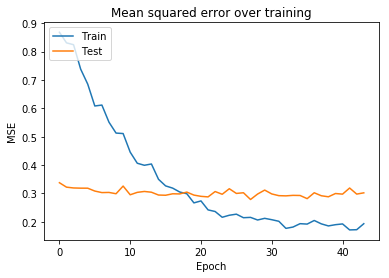

{'num_hidden_layers': [1], 'hidden_layer_size': [128], 'activation_function': ['relu']}


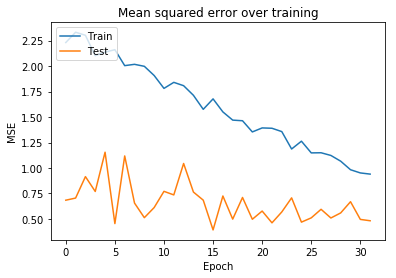

{'num_hidden_layers': [3], 'hidden_layer_size': [128], 'activation_function': ['linear']}


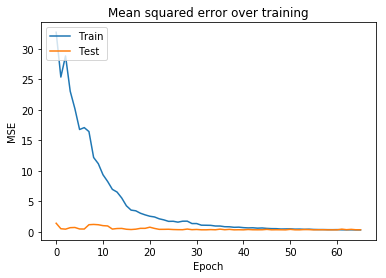

{'num_hidden_layers': [2], 'hidden_layer_size': [256], 'activation_function': ['sigmoid']}


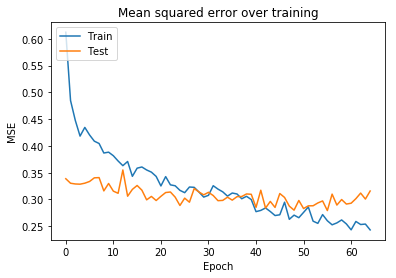

{'num_hidden_layers': [3], 'hidden_layer_size': [256], 'activation_function': ['sigmoid']}


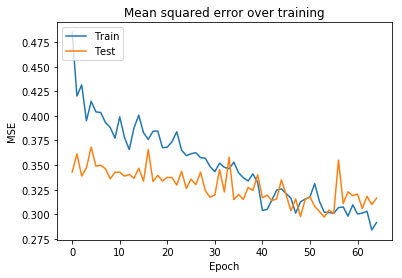

In [164]:
for i, k in enumerate(list(model_info.keys())): 
    print(final_models[i][0])
    plt.plot(model_info[k]['history']['loss'][2:])
    plt.plot(model_info[k]['history']['val_loss'][2:])
    plt.title('Mean squared error over training')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

The first and third models both show evidence of overfitting, as training performance continued to improve as validation performance plateaued (as seen when the blue line goes below the orange line). This suggests that these models will perform worse on the out-of-sample data.

Now I store and upload the predictions of each model to obtain the results on the true held out data.

In [166]:
for i, k in enumerate(list(model_info.keys())):
    predictions['gpa'] = model_info[k]['preds']
    name = 'final_predictions_model_'+str(i)+'.csv'
    predictions.to_csv(name)
    # csvs were then uploaded to the challenge website: https://codalab.fragilefamilieschallenge.org/#participate-submit_results

It is useful to compare to the predicted values for the test data.

In [174]:
# Printing performance on validation set
for k,v in model_info.items():
    print(mean_squared_error(y_test, v['grid_obj'].predict(np.array(X_test))))

0.302232599543
0.482352497173
0.317887099487
0.315795403041
0.316432194806


In [269]:
# Store all five model objects
for k,v in model_info.items():
    v['keras_model'].save(k+'.h5')

## Scores on held out challenge set

0.41737 (Submission 27)


0.64386  (Submission 28) Unsurprising since it looks like it didn't have enough time before it stopped and also performed poorly on the test set


0.42533  (Submission 29)


0.43441 (Submission 30)


0.37975 (Submission 31)

The fifth model with 3 hidden layers, each consisting of 256 units, with a sigmoid activation worked best.